## Importing needed packages

In [13]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
from scipy.stats import norm
from DataHandling import *
from ModelClasses import *
import matplotlib.pyplot as plt

## Defining Input Parameters

In [14]:
# Define number of hours as length of demand
N_Hours = hours_per_year

# Define number of generators as length of CapCost
N_Cap = len(CapCost)

# Define number of storage as length of StorCost
N_Stor = len(StorCost)

# Define number of scenarios as number of columns in ProdFacWind
N_Scen = scenarios_per_year * len(years)

# Define epsilon
epsilon = 0.1

#Define delta
delta = 0.8

BigM = 1000000


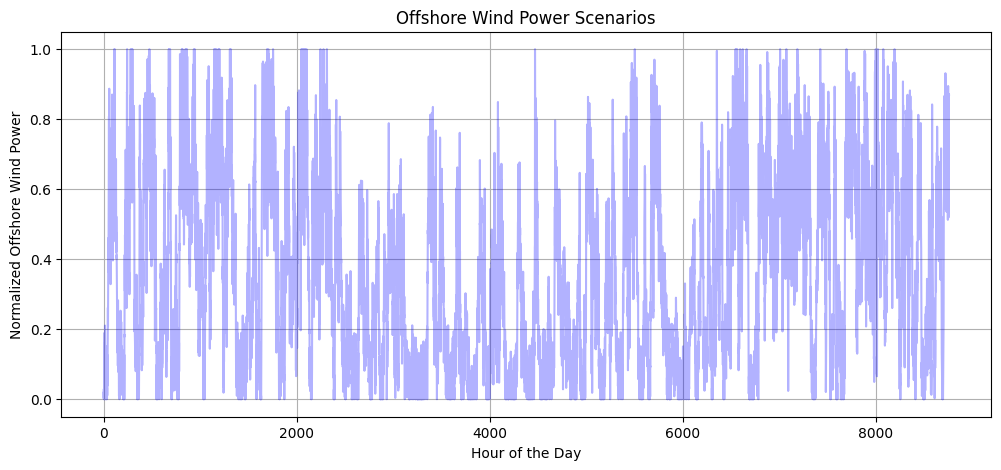

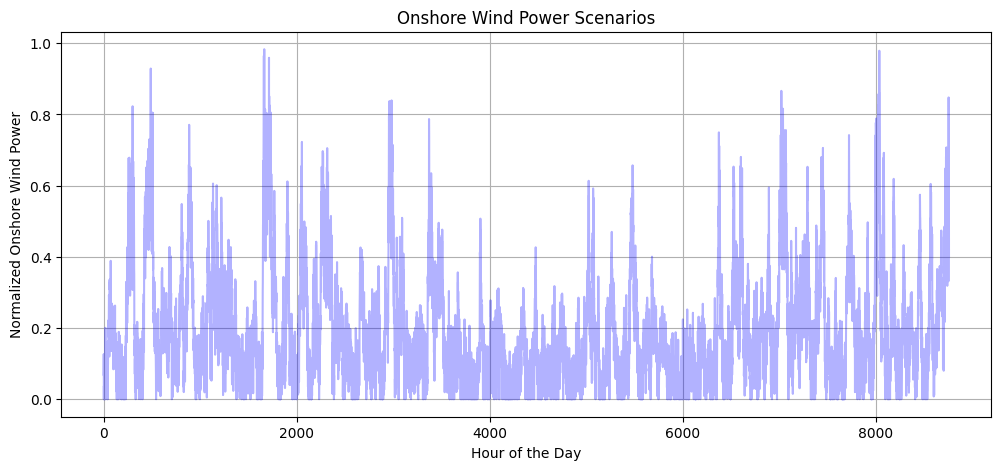

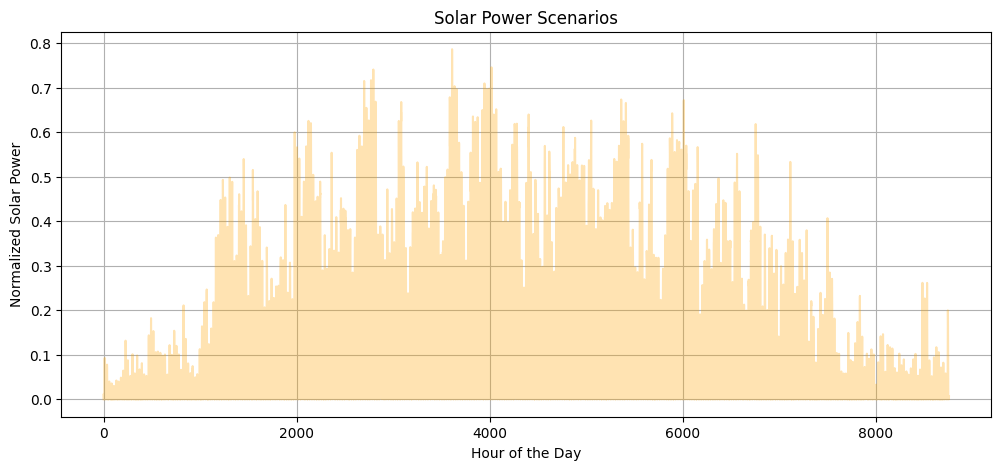

In [15]:


# Plot offshore Wind Scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen): 
    plt.plot(range(N_Hours), Offwind_scenarios[:, scenario], alpha=0.3, color='blue')
plt.title("Offshore Wind Power Scenarios")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Offshore Wind Power")
plt.grid(True)
plt.show()

# Plot onshore Wind Scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen):  
    plt.plot(range(N_Hours), Onwind_scenarios[:, scenario], alpha=0.3, color='blue')
plt.title("Onshore Wind Power Scenarios")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Onshore Wind Power")
plt.grid(True)
plt.show()

# Plot Solar Scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen): 
    plt.plot(range(N_Hours), Solar_scenarios[:, scenario], alpha=0.3, color='orange')
plt.title("Solar Power Scenarios")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Solar Power")
plt.grid(True)
plt.show()

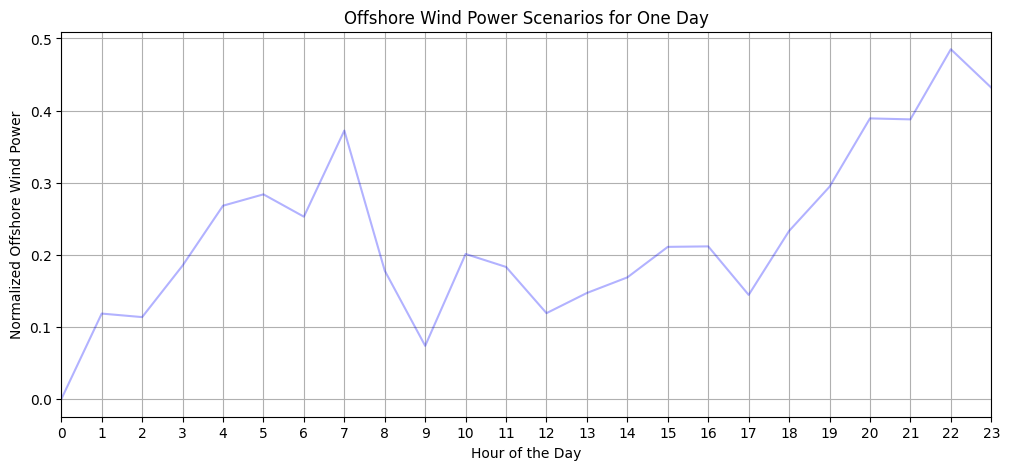

In [16]:
#Plot one day of offshore wind scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen):  # Plot only first 50 scenarios for clarity
    plt.plot(range(24), Offwind_scenarios[4000:4024, scenario], alpha=0.3, color='blue')
plt.title("Offshore Wind Power Scenarios for One Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Offshore Wind Power")
plt.grid(True)
plt.xlim(0, 23)  # Limit x-axis to 24 hours
plt.xticks(range(24))  # Set x-ticks to show each hour
plt.show()

## Creating Data and Parameter Objects

In [17]:
ParametersObj = Parameters(epsilon, delta, N_Hours, N_Cap, N_Stor, N_Scen, BigM)
DataObj = InputData(CapCost, OpCost, TechInfo, StorCost, CapLim,CapExi,CapOut,Demand,EtaCh,EtaDis,StorExi, Offwind_scenarios, Onwind_scenarios, Solar_scenarios, StorLim)


## Execute the capacity investment model

In [18]:
CapacityProblem = CapacityProblem(ParametersObj, DataObj)
#CapacityProblem._results()
#CapacityProblem._extract_results()

ResultsCapacity = CapacityProblem.res.CapNew
ResultsStorage = CapacityProblem.res.CapStor
#ResultsViolations = CapacityProblem.res.Violation_Scenarios

for scenario_name, df in CapacityProblem.res.EGen_Scenarios.items():
    df.to_csv(f"{scenario_name}.csv", index=False)  # Save each scenario as a CSV file
    print(f"Saved {scenario_name}.csv")

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 183976 rows, 157695 columns and 601199 nonzeros
Model fingerprint: 0x6bb80dd5
Variable types: 157694 continuous, 1 integer (1 binary)
Coefficient statistics:
  Matrix range     [2e-06, 1e+06]
  Objective range  [2e+04, 9e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-04, 4e+05]
Presolve removed 73354 rows and 20785 columns
Presolve time: 0.89s
Presolved: 110622 rows, 136910 columns, 416213 nonzeros
Variable types: 136910 continuous, 0 integer (0 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   33836    5.2246581e+11   0.000000e+00   1.444248e+11      5s
   40952    4.6745

## Create Market Clearing class

In [19]:
class DayAheadProblem():
    def __init__(self, ParametersObj, DataObj, GenerationCapacity, StorageCapacity, Model_results = 1, Guroby_results = 1):
        self.P = ParametersObj # Parameters
        self.D = DataObj # Data
        self.Model_results = Model_results
        self.Guroby_results = Guroby_results
        self.GenCap = GenerationCapacity
        self.StorCap = StorageCapacity
        self.var = Expando()  # Variables
        self.con = Expando()  # Constraints
        self.res = Expando()  # Results
        self._build_model() 


    def _build_variables(self):
        # Create the variables
        self.var.EGen = self.m.addMVar((self.P.N_Cap, self.P.N_Hours, self.P.N_Scen), lb=0)  # Variable for generation for each scenario, technology, and hour
        self.var.SOC = self.m.addMVar((self.P.N_Stor, self.P.N_Hours, self.P.N_Scen), lb=0)  # Variable for state of charge for each scenario, storage technology, and hour
        self.var.EChar = self.m.addMVar((self.P.N_Stor, self.P.N_Hours, self.P.N_Scen), lb=0)  # Variable for energy charge for each scenario, storage technology, and hour
        self.var.EDis = self.m.addMVar((self.P.N_Stor, self.P.N_Hours, self.P.N_Scen), lb=0)  # Variable for energy discharge for each scenario, storage technology, and hour

    def _build_constraints(self):

        G, H, S, U = self.P.N_Cap, self.P.N_Hours, self.P.N_Scen, self.P.N_Stor
    
        # Generation capacity constraint
        CapTotal = self.GenCap.reshape((G, 1, 1)) + self.D.CapExi.reshape((G, 1, 1)) + self.D.CapOut.reshape((G, 1, 1))


        Techs = self.D.TechInfo['Technology'].values
        OffshoreMask = (Techs == 'Wind Offshore')
        OnshoreMask = (Techs == 'Wind Onshore')
        SolarMask = (Techs == 'PV')
        ConvMask = ~(OffshoreMask | OnshoreMask | SolarMask)

        if OffshoreMask.any():
            self.con.ProdLim_Offshore = self.m.addConstr(
                self.var.EGen[OffshoreMask, :, :] <= CapTotal[OffshoreMask, :, :] * self.D.Offwind_scenarios[None, :, :],
                name='ProdLimit_Offshore'
            )
        if OnshoreMask.any():
            self.con.ProdLim_Onshore = self.m.addConstr(
                self.var.EGen[OnshoreMask, :, :] <= CapTotal[OnshoreMask, :, :] * self.D.Onwind_scenarios[None, :, :],
                name='ProdLimit_Onshore'
            )
        if SolarMask.any():
            self.con.ProdLim_Solar = self.m.addConstr(
                self.var.EGen[SolarMask, :, :] <= CapTotal[SolarMask, :, :] * self.D.Solar_scenarios[None, :, :],
                name='ProdLimit_Solar'
            )
        if ConvMask.any():
            self.con.ProdLim_Conv = self.m.addConstr(
                self.var.EGen[ConvMask, :, :] <= CapTotal[ConvMask, :, :],
                name='ProdLimit_Conventional'
            )

        # Energy Balance constraint
        EGen_sum = self.var.EGen.sum(axis=0)    # shape (H, S)
        EDis_sum = self.var.EDis.sum(axis=0)    # shape (H, S)
        EChar_sum = self.var.EChar.sum(axis=0)  # shape (H, S)
        Demand_scaled = self.D.Dem[:H, None]  # shape (H, 1), broadcast to (H, S)

        self.con.Balance = self.m.addConstr(EGen_sum + EDis_sum == Demand_scaled + EChar_sum, name='EnergyBalance')


        #Defining SOC, Charge and Discharge for each scenario and each hour >0
        SOC = self.var.SOC
        EChar = self.var.EChar
        EDis = self.var.EDis
        SOC_prev = SOC[:, :-1, :]  # (U, H-1, S)
        EChar_prev = EChar[:, :-1, :]
        EDis_prev = EDis[:, :-1, :]
        SOC_curr = SOC[:, 1:, :]

        # Defining SOC as results of previous hours
        self.con.SOC_Update = self.m.addConstr(SOC_curr == SOC_prev + EChar_prev - EDis_prev, name='SOC_Update')

        # Defining Initial SOC
        self.con.SOC0 = self.m.addConstr(SOC[:, 0, :] == self.D.StorExi[:, None] + self.StorCap[:,None], name='SOC_Initial')

        # Limit SOC by existing storage capacity and new storage capacity
        self.con.SOCLim = self.m.addConstr(
            SOC <= self.StorCap[:, None, None] + self.D.StorExi[:, None, None],
            name='StorageCapLimit'
        )

        # Limit charge by existing storage capacity and new storage capacity - SOC
        self.con.ECharLim = self.m.addConstr(
            EChar <= self.StorCap[:, None, None] + self.D.StorExi[:, None, None] - SOC,
            name='ECharLimit'
        )
        # Limit Discharge by SOC
        self.con.EDisLim = self.m.addConstr(
            EDis <= SOC,
            name='EDisLimit'
        )

        
    
    def _build_objective(self):

        # Vectorized operational cost for generation multiplied by generation
        op_cost = (self.var.EGen * self.D.OpCost[:, None, None]).sum() 

        # Set objective, minimizing total costs
        self.m.setObjective( op_cost, GRB.MINIMIZE)


    def _display_guropby_results(self):
        self.m.setParam('OutputFlag', self.Guroby_results)

    
    def _build_model(self):
        self.m = gp.Model('CapacityProblem')
        self._build_variables()
        self._build_constraints()
        self._build_objective()
        self._display_guropby_results()
        self.m.write("CapacityProblem.lp")
        self.m.optimize()
        self._results()
        if self.Model_results == 1:
            self._extract_results()
            

    
    def _results(self):
        self.res.obj = self.m.objVal
        # self.res.CapNew = self.var.CapNew.X
        # self.res.EGen = self.var.EGen.X
        # self.res.CapStor = self.var.CapStor.X
        # self.res.SOC = self.var.SOC.X
        # self.res.EChar = self.var.EChar.X
        # self.res.EDis = self.var.EDis.X
        # self.res.u = self.var.u.X
        # # Calculate RES Share for each scenario
        # self.res.RESShare = np.zeros((self.P.N_Scen, 1))
        # for s in range(self.P.N_Scen):
        #     self.res.RESShare[s] =   np.sum(self.res.EGen[:, :, s][self.D.TechInfo['Type'] == 'RES'])/np.sum(self.D.Dem)
         
        # # Total number of constraints
        # self.res.TotalConstraints = self.m.NumConstrs

        # # Count number of active constraints
        # def count_active_constraints(model, tol=1e-6):
        #     model.update()  # Make sure model is up to date
        #     active = 0
        #     for c in model.getConstrs():
        #         slack = c.getAttr("Slack")
        #         sense = c.Sense

        #         if sense == '=' and abs(slack) <= tol:
        #             active += 1
        #         elif sense == '<' and abs(slack) <= tol:
        #             active += 1
        #         elif sense == '>' and abs(slack) <= tol:
        #             active += 1
        #     return active


        # self.res.ActiveConstraints = count_active_constraints(self.m)

        # #Create Dataframe for new capacity
        # self.res.CapNew = pd.DataFrame({
        #     'Plant': ['Offshore', 'Onshore', 'Biomass', 'Lignite', 'Hard Coal', 'Gas', 'Hydrogren', 'Nuclear', 'Solar PV', 'Hydro', 'Other RES', 'Other Conventional'],
        #     'CapNew[MW]': self.res.CapNew,
        #     'CapExi[MW]': self.D.CapExi,
        #     'CapOut[MW]': self.D.CapOut
        # })

        # #Create Dataframe for new storage capacity
        # self.res.CapStor = pd.DataFrame({
        #     'Plant': ['Battery', 'Pumped Hydro'],
        #     'CapStor[MWh]': self.res.CapStor
        # })

        # # Create DataFrame for scenario violations
        # self.res.Violation_Scenarios = pd.DataFrame({
        #     'Scenario': list(range(self.P.N_Scen)),
        #     'Violated (1=No, 0=Yes)': self.res.u
        # })
        
        
    

        # self.res.EGen_Scenarios = {}

        # for s in range(self.P.N_Scen):
        #     # Extract data for scenario `s`
        #     e_gen_scenario = self.res.EGen[:, :, s].T  
        #     soc_scenario = self.res.SOC[:, :, s].T  
        #     echar_scenario = self.res.EChar[:, :, s].T  
        #     edis_scenario = self.res.EDis[:, :, s].T  

        #     # Extract Wind and Solar Production Factors
        #     Offwind_scenarios = self.D.Offwind_scenarios[:, s]  
        #     Onwind_scenarios = self.D.Onwind_scenarios[:, s]  
        #     Solar_scenarios = self.D.Solar_scenarios[:, s]  

        #     # Convert to DataFrames
        #     df_scenario = pd.DataFrame(e_gen_scenario, columns=['Offshore', 'Onshore', 'Biomass', 'Lignite', 'Hard Coal', 'Gas', 'Hydrogren', 'Nuclear', 'Solar PV', 'Hydro', 'Other RES', 'Other Conventional'])
        #     df_soc = pd.DataFrame(soc_scenario, columns=['Battery_SOC', 'PumpedHydro_SOC'])
        #     df_echar = pd.DataFrame(echar_scenario, columns=['Battery_Charge', 'PumpedHydro_Charge'])
        #     df_edis = pd.DataFrame(edis_scenario, columns=['Battery_Discharge', 'PumpedHydro_Discharge'])
        #     df_demand = pd.DataFrame({'Demand': self.D.Dem})

        #     # Add Wind & Solar Production Factors
        #     df_prod_factors = pd.DataFrame({'OffWind': Offwind_scenarios, 'OnWind': Onwind_scenarios, 'Solar': Solar_scenarios})

        #     # Add Hour column
        #     df_scenario['Hour'] = list(range(self.P.N_Hours))

        #     # Merge all DataFrames
        #     df_complete = pd.concat([df_scenario, df_soc, df_echar, df_edis, df_demand, df_prod_factors], axis=1)

        #     # Reorder columns
        #     df_complete = df_complete[['Hour', 'Offshore', 'Onshore', 'Biomass', 'Lignite', 'Hard Coal', 'Gas', 'Hydrogren', 'Nuclear', 'Solar PV', 'Hydro', 'Other RES', 'Other Conventional',
        #                             'Battery_SOC', 'PumpedHydro_SOC',
        #                             'Battery_Charge', 'PumpedHydro_Charge',
        #                             'Battery_Discharge', 'PumpedHydro_Discharge',
        #                             'Demand', 'OffWind','OnWind', 'Solar']]

        #     # Store in dictionary
        #     self.res.EGen_Scenarios[f"Scenario_{s}"] = df_complete
    

    def _extract_results(self):
        # Display the objective value
        print('Objective value: ', self.m.objVal)
        # # Display the new capacity for each type of generator technology
        # print('New capacity for each type of generator technology: ', self.res.CapNew)
        
        # #Display new storage capacity for each type of storage technology
        # print('New storage capacity for each type of storage technology: ', self.res.CapStor)

        # # Display RES Share for each scenario
        # print('RES Share for each scenario: ', self.res.RESShare)

         # Print constraint info
        # print(f"Total number of constraints: {self.res.TotalConstraints}")
        # print(f"Number of active (binding) constraints: {self.res.ActiveConstraints}")


In [20]:
ResultsCapacity = np.array(CapacityProblem.res.CapNew['CapNew[MW]'])
ResultsStorage = np.array(CapacityProblem.res.CapStor['CapStor[MWh]'])

In [21]:
DayAheadProblem = DayAheadProblem(ParametersObj, DataObj, ResultsCapacity, ResultsStorage)

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 183960 rows, 157680 columns and 402954 nonzeros
Model fingerprint: 0x1c4a5cc1
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+04, 4e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-04, 2e+02]
Presolve removed 136682 rows and 75362 columns
Presolve time: 0.47s
Presolved: 47278 rows, 82318 columns, 246870 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.06s

Barrier statistics:
 AA' NZ     : 3.116e+05
 Factor NZ  : 6.885e+05 (roughly 60 MB of memory)
 Factor Ops : 1.089e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual